In this jupter notebook we will be running deterministic simulations to characterize naive, differentiation, and terminal differentiation architectures as shown in Figure 1 and Figure S1. Full descriptions of the models being implemented refer to the model implementation section of the methods.

In [2]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate
import scipy.signal
import numba 
import pandas as pd
import time
# Plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numba
import time
import pickle
from cycler import cycler
import itertools
import multiprocessing as MP
import warnings
# from differentiation_functions_ODE import *

# Pretty plot settings from Anandh
# mpl.font_manager._rebuild()
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 14, 'axes.titlesize': 14,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

We first write functions for setting up simulations for naïve expression, differentiation, and terminal differentiations. While in this notebook we are only running deterministic simulations describing the single cassette case (1x naïve, etc.), the functions we have written allow specification of the number of cassettes for each circuit. This functions have then been further developed for the simulations described in Figure 3. These functions (1) create genotypes, (2) enumerate mutation and differentiation reactions and incorporate them into ODEs describing cell growth, differentiation, mutations, and production of the function of interest, and (3) run the simulations. 

In [3]:
"""
Functions below are for the simulation of the naive circuit
"""
def naive_multicassette_mut_list_fixed_step(kMB, muN, muP, beta_p, n_cassettes,
                                   selection='recessive'):
    
    # create unique genotypes
    states=np.array(['P','N'])
    x = itertools.combinations_with_replacement(states,n_cassettes)
    num_gens = sum(1 for i in x)
    gens = np.empty((num_gens,n_cassettes),'<U2')
    x = itertools.combinations_with_replacement(states,n_cassettes)
    for i, gen in enumerate(x):
        for j in range(n_cassettes):
            gens[i,j] = gen[j]
    
    # production rate and growth rate arrays
    beta_ps = np.zeros(len(gens))
    mus = np.ones(len(gens))*muN
    
    # create and fill out lists of source/dest/rates      
    source_list = []
    dest_list = []
    rate_list = []
    ps = np.zeros(len(gens),int)
    ns = np.zeros(len(gens),int)
    for i, c1 in enumerate(gens):
        ps[i] = np.sum(c1=='P')
        ns[i] = np.sum(c1=='N')
        if ps[i]>0: # if at least one producer cassette, producer growth growth and production is on
            if selection == 'additive':
                mus[i] = muN - ps[i]/n_cassettes*(muN-muP)
                beta_ps[i] = beta_p*ps[i]/n_cassettes
            elif selection == 'recessive':
                mus[i] = muP
                beta_ps[i] = beta_p
            else:
                print('defaulting to recessive selection')
                mus[i] = muP
                beta_ps[i] = beta_p

    for i in range(num_gens):
        if ps[i]>0:
            mutb_to = np.argwhere(((ps==ps[i]-1)&\
                                   (ns==ns[i]+1))).flatten()[0]
            source_list += [i]
            dest_list += [mutb_to]
            rate_list += [ps[i]*kMB]
            
    # make full list of genotypes
    species = ['',]*len(gens)
    for i in range(num_gens):
        for c in gens[i]: species[i] += c
    
    # make dictionary of producer, progenitor producer, mutant, and non-producer genotypes
    producer_gens = []
    producer_gens_ind = []
    nonproducer_gens = []
    nonproducer_gens_ind = []
    for i in range(len(gens)):
        if ps[i] > 0: 
            producer_gens += [species[i]]
            producer_gens_ind += [i]
        else: 
            nonproducer_gens += [species[i]]
            nonproducer_gens_ind += [i]
    pn_dict = {'producers':producer_gens,'mutants':nonproducer_gens,'cheaters':nonproducer_gens}
    pn_ind_dict = {'producers':producer_gens_ind,'mutants':nonproducer_gens_ind,'cheaters':nonproducer_gens_ind}
    
    return np.array(source_list), np.array(dest_list),\
               np.array(rate_list), mus, beta_ps, pn_dict, pn_ind_dict
    
@numba.jit(nopython=True)
def multicassette_naive_fixed_step_update(
    concs,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,mut
    ):
    
    # allocate array for ddts
    ddts = np.zeros(len(concs))

    # total cell count
    ctot = concs[0:-1].sum()

    # carrying capacity limited growth and production
    MOD = (K-ctot)/K
    
    # growth and washout of cells
    ddts[0:-1] += mus*MOD*concs[0:-1]*dt - D*concs[0:-1]*dt
    
    # production
    ddts[-1] += np.sum(concs[0:-1]*MOD*beta_ps)*dt
    
    # mutation
    if mut:
        if stochastic:
#             concs[0:-1] += multicassette_naive_fs_mut_stochastic(source,dest,rates*dt_mut,concs[0:-1])
            ddts[0:-1] += multicassette_naive_fs_mut_stochastic(source,dest,mus[source]*MOD*rates*dt_mut,concs[0:-1])
        else:
#             concs[0:-1] += multicassette_naive_fs_mut_determ(source,dest,rates*dt_mut,concs[0:-1])
            ddts[0:-1] += multicassette_naive_fs_mut_determ(source,dest,mus[source]*MOD*rates*dt_mut,concs[0:-1])
    
    return concs + ddts

@numba.jit(nopython=True)
def multicassette_naive_fs_mut_stochastic(source,dest,rates,concs):
    mut_update = np.zeros(len(concs))
    for i in range(len(source)):
        if concs[source[i]]>1:
            n_mut = np.random.binomial(int(concs[source[i]]),rates[i])
            mut_update[source[i]] -= n_mut
            mut_update[dest[i]] += n_mut
    return mut_update

@numba.jit(nopython=True)
def multicassette_naive_fs_mut_determ(source,dest,rates,concs):
    mut_update = np.zeros(len(concs))
    for i in range(len(source)):
        if concs[source[i]]>0:
            n_mut = concs[source[i]]*rates[i]
            mut_update[source[i]] -= n_mut
            mut_update[dest[i]] += n_mut
    return mut_update

    

@numba.jit(nopython=True)
def multicassette_naive_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                         frac_at_dilution):
    for i in range(out.shape[0]-1):
        if round(i*dt/dt_mut,6) == int(round(i*dt/dt_mut,6)):    
            i_1 = multicassette_naive_fixed_step_update(out[i,:],K,D,source,dest,rates,mus,
                                                    beta_ps,dt,dt_mut,stochastic,True)
        else:
            i_1 = multicassette_naive_fixed_step_update(out[i,:],K,D,source,dest,rates,mus,
                                                    beta_ps,dt,dt_mut,stochastic,False)
        i_1[i_1<0] = 0
        out[i+1,:] = i_1
    
    pop_tots = out[:,0:-1].sum(axis=1)
    
    if pop_tots[-1] < (frac_at_dilution*K):
        return out
    else:
        end_loc = do_argwhere(pop_tots,K,frac_at_dilution)
        return out[0:end_loc,:]
    

@numba.jit(nopython=True)
def do_argwhere(pop_tots,K,frac_at_dilution):
    for i in range(len(pop_tots)):
        if pop_tots[i] > frac_at_dilution*K:
            return i
        
def multicassette_naive_fixed_step_batch(t, dt, dt_mut, cell_init, n_cassettes, muN, muP,
                                   beta_p, kMB, K, D=0, dilution_factor=50, 
                                   frac_at_dilution=0.95,prod_frac_thresh=1e-3,
                                   stochastic=False,max_growths=None,selection='recessive'):
    if int(dt_mut/dt) != (dt_mut/dt):
        print('dt_mut must be an integer multiple of dt')
        return

    source, dest, rates, mus, beta_ps, pn_dict, pn_ind_dict = \
            naive_multicassette_mut_list_fixed_step(kMB, muN, muP, beta_p, 
                                            n_cassettes, selection)
    
    
    concs = np.zeros(len(mus)+1)
    concs[0] = cell_init
    production = 0
    dilute_again = True
    producer_locs = pn_ind_dict['producers']
    nonproducer_locs = pn_ind_dict['mutants']
    n=0
    while dilute_again:
        out = np.zeros((int(t/dt)+1,len(concs)))
        out[0,:]=concs
        out = multicassette_naive_fixed_step_growth(out,K,D,source,dest,rates,mus,
                                                    beta_ps,dt,dt_mut, stochastic,frac_at_dilution)
        end_concs = out[-1,:]
        if n == 0:
            out_concat = out
        else:
            out_concat = np.concatenate((out_concat,out))
        if type(max_growths) is int:
            if n+1 >= max_growths:
                dilute_again = False
        if end_concs[0:-1].sum() < 2*dilution_factor:
            dilute_again = False
        elif end_concs[0:-1].sum() < 0.02*K:
            dilute_again = False
        elif (end_concs[producer_locs].sum()/end_concs[0:-1].sum()) < prod_frac_thresh:
            dilute_again = False
       
        else:
            concs = end_concs
            if np.any(concs<0):
                concs[concs<0] = 0
            if np.any(np.isnan(concs)):
                print('nan')
            if stochastic:
                concs[0:-1] = np.random.binomial(list(concs[0:-1]),1/dilution_factor)
            else:
                concs[0:-1] /= dilution_factor
        n +=1
    return out_concat, pn_dict, pn_ind_dict, n
"""
Functions below are for the simulation of the differentiation architecture without selection
"""
def diff_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                           n_cassettes,return_gens=False):


    states=np.array(['PP','PN','DP','DN','M-'])
    x = itertools.combinations_with_replacement(states,n_cassettes)
    num_gens = sum(1 for i in x)
    gens = np.empty((num_gens,n_cassettes),'<U2')
    x = itertools.combinations_with_replacement(states,n_cassettes)
    for i, gen in enumerate(x):
        for j in range(n_cassettes):
            gens[i,j] = gen[j]
    pps = np.zeros(len(gens),int)
    pns = np.zeros(len(gens),int)
    dps = np.zeros(len(gens),int)
    dns = np.zeros(len(gens),int)
    m_s = np.zeros(len(gens),int)
    beta_ps = np.zeros(len(gens))
    mus = np.ones(len(gens))*muN

    # create and fill out matrix with rates
    source_list = []
    dest_list = []
    rate_list = []
    for i, c1 in enumerate(gens):
        pps[i] = np.sum(c1=='PP')
        pns[i] = np.sum(c1=='PN')
        dps[i] = np.sum(c1=='DP')
        dns[i] = np.sum(c1=='DN')
        m_s[i] = np.sum(c1=='M-')
        if dps[i]>0:
            mus[i] = muP
            beta_ps[i] = beta_p
    
    for i in range(num_gens):
        if pps[i]>0:
            # Differentiation
            diff_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i])&\
                                   (dps==dps[i]+1)&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [diff_to]
#             rate_list += [pps[i]*kdiff]
            rate_list += [kdiff]
            
            # Burden mutation
            mutb_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i]+1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [mutb_to]
            rate_list += [pps[i]*kMB]
    
            # Differentiation mutation
            mutd_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i])&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]+1))).flatten()[0]
            source_list += [i]
            dest_list += [mutd_to]
            rate_list += [pps[i]*kMD]

        if pns[i]>0:
            # Differentiation
            diff_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i]-1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i]+1)&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [diff_to]
#             rate_list += [pns[i]*kdiff]
            rate_list += [kdiff]
        
            # Differentiation mutation
            mutd_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i]-1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]+1))).flatten()[0]
            source_list += [i]
            dest_list += [mutd_to]
            rate_list += [pns[i]*kMD]
        if dps[i]>0:
            # Burden mutation
            mutb_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i])&\
                                   (dps==dps[i]-1)&\
                                   (dns==dns[i]+1)&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [mutb_to]
            rate_list += [dps[i]*kMB]
    
    # make full list of genotypes
    species = ['',]*len(gens)
    for i in range(num_gens):
        for c in gens[i]: species[i] += c
            
    # make dictionary of producer, progenitor producer, mutant, and non-producer genotypes
    producer_gens = []
    progenitor_gens = []
    mutant_gens = []
    producer_gens_ind = []
    progenitor_gens_ind = []
    mutant_gens_ind = []
    cheater_gens = []
    cheater_gens_ind = []
    defector_gens = []
    defector_gens_ind = []
    
    for i in range(len(gens)):
        if dps[i] > 0: 
            producer_gens += [species[i]]
            producer_gens_ind += [i]
        elif pps[i] > 0: 
            progenitor_gens += [species[i]]
            progenitor_gens_ind += [i]
        else: 
            mutant_gens += [species[i]]
            mutant_gens_ind += [i]
        if m_s[i] == n_cassettes:
            defector_gens += [species[i]]
            defector_gens_ind += [i]
        elif dps[i] == 0 and pps[i] == 0:
            if (pns[i]+dns[i]) > 0:
                cheater_gens += [species[i]]
                cheater_gens_ind += [i]
    ppm_dict = {'producers':producer_gens,'progenitors':progenitor_gens,'mutants':mutant_gens,
               'cheaters':cheater_gens,'defectors':defector_gens}
    ppm_ind_dict = {'producers':producer_gens_ind,'progenitors':progenitor_gens_ind,'mutants':mutant_gens_ind,
                   'cheaters':cheater_gens_ind,'defectors':defector_gens_ind}
    return np.array(source_list), np.array(dest_list),\
               np.array(rate_list), mus, beta_ps, ppm_dict, ppm_ind_dict

@numba.jit(nopython=True)
def multicassette_diff_fixed_step_update(concs,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,mut):
    # allocate array for ddts
    ddts = np.zeros(len(concs))

    # total cell count
    ctot = concs[0:-1].sum()

    # fraction to modify growth rates and production rates
    MOD = (K-ctot)/K
    
    # growth and washout of cells
    ddts[0:-1] += mus*MOD*concs[0:-1]*dt - D*concs[0:-1]*dt
    
    # production
    ddts[-1] += np.sum(concs[0:-1]*MOD*beta_ps)*dt
    
    if mut:
        if stochastic:
#             concs[0:-1] += multicassette_diff_fs_mut_stochastic(source,dest,rates*dt_mut,concs[0:-1])
            ddts[0:-1] += multicassette_diff_fs_mut_stochastic(source,dest,mus[source]*MOD*rates*dt_mut,concs[0:-1])
        else:
#             concs[0:-1] += multicassette_diff_fs_mut_determ(source,dest,rates*dt_mut,concs[0:-1])
            ddts[0:-1] += multicassette_diff_fs_mut_determ(source,dest,mus[source]*MOD*rates*dt_mut,concs[0:-1])

    return concs + ddts

@numba.jit(nopython=True)
def multicassette_diff_fs_mut_stochastic(source,dest,rates,concs):
    mut_update = np.zeros(len(concs))
    for i in range(len(source)):
        if concs[source[i]]>1:
            n_mut = np.random.binomial(int(concs[source[i]]),rates[i])
            mut_update[source[i]] -= n_mut
            mut_update[dest[i]] += n_mut
    return mut_update

@numba.jit(nopython=True)
def multicassette_diff_fs_mut_determ(source,dest,rates,concs):
    mut_update = np.zeros(len(concs))
    for i in range(len(source)):
        if concs[source[i]]>0:
            n_mut = concs[source[i]]*rates[i]
            mut_update[source[i]] -= n_mut
            mut_update[dest[i]] += n_mut
    return mut_update

@numba.jit(nopython=True)
def multicassette_diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                         frac_at_dilution):
    for i in range(out.shape[0]-1):
        if round(i*dt/dt_mut,6) == int(round(i*dt/dt_mut,6)):  
            i_1 = multicassette_diff_fixed_step_update(out[i,:],K,D,source,dest,rates,mus,
                                                       beta_ps,dt,dt_mut,stochastic,True)
        else:
            i_1 = multicassette_diff_fixed_step_update(out[i,:],K,D,source,dest,rates,mus,
                                                       beta_ps,dt,dt_mut,stochastic,False)
        i_1[i_1<0] = 0
        out[i+1,:] = i_1
    pop_tots = out[:,0:-1].sum(axis=1)
    if pop_tots[-1] < (frac_at_dilution*K):
        return out
    else:
        end_loc = do_argwhere(pop_tots,K,frac_at_dilution)
    return out[0:end_loc,:]
    

"""
Functions below are for the simulation of the differentiation with selection architecture (both the identical cassette and split cassette versions)
"""
def diff_select_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                           n_cassettes,n_div):

    states=np.array(['PP','PN','DP','DN','M-'])
    x = itertools.combinations_with_replacement(states,n_cassettes)
    num_gens = sum(1 for i in x)
    gens = np.empty((num_gens,n_cassettes),'<U2')
    x = itertools.combinations_with_replacement(states,n_cassettes)
    for i, gen in enumerate(x):
        for j in range(n_cassettes):
            gens[i,j] = gen[j]
    pps = np.zeros(len(gens),int)
    pns = np.zeros(len(gens),int)
    dps = np.zeros(len(gens),int)
    dns = np.zeros(len(gens),int)
    m_s = np.zeros(len(gens),int)
    
    for i, c1 in enumerate(gens):
        pps[i] = np.sum(c1=='PP')
        pns[i] = np.sum(c1=='PN')
        dps[i] = np.sum(c1=='DP')
        dns[i] = np.sum(c1=='DN')
        m_s[i] = np.sum(c1=='M-')
        
    
    lim_div_locs = np.argwhere(dps+dns==n_cassettes).flatten()
    lim_div_gens = gens[lim_div_locs]
    lim_div_dps = dps[lim_div_locs]
    lim_div_dns = dns[lim_div_locs]
    
    
    # create and fill out matrix with rates        
    source_list = []
    dest_list = []
    rate_list = []
    beta_ps = np.zeros(len(gens)+n_div*len(lim_div_gens))
    mus = np.ones(len(gens)+n_div*len(lim_div_gens))*muN
    
    for i, c1 in enumerate(gens):
        if dps[i]>0:
            mus[i] = muP
            beta_ps[i] = beta_p
        if i in lim_div_locs:
            mus[i] *= -1
    
    for i in range(num_gens):
        if pps[i]>0:
            # Differentiation
            diff_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i])&\
                                   (dps==dps[i]+1)&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [diff_to]
            rate_list += [kdiff]
#             rate_list += [pps[i]*kdiff]

            # Burden mutation
            mutb_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i]+1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [mutb_to]
            rate_list += [pps[i]*kMB]
            
            # Differentiation mutation
            mutd_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i])&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]+1))).flatten()[0]
            source_list += [i]
            dest_list += [mutd_to]
            rate_list += [pps[i]*kMD]

        if pns[i]>0:
            # Differentiation
            diff_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i]-1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i]+1)&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [diff_to]
            rate_list += [kdiff]
#             rate_list += [pns[i]*kdiff]
            
            # Differentiation mutation
            mutd_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i]-1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]+1))).flatten()[0]
            source_list += [i]
            dest_list += [mutd_to]
            rate_list += [pns[i]*kMD]

        if dps[i]>0:
            # Burden mutation
            mutb_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i])&\
                                   (dps==dps[i]-1)&\
                                   (dns==dns[i]+1)&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [mutb_to]
            rate_list += [dps[i]*kMB]
    for i, c1 in enumerate(lim_div_gens):
        if dps[lim_div_locs[i]] > 0:
            mutb_to = np.argwhere(((lim_div_dps==lim_div_dps[i]-1)&\
                                   (lim_div_dns==lim_div_dns[i]+1))).flatten()[0]
            mus[len(gens)+i::len(lim_div_gens)] = -muP
            beta_ps[len(gens)+i::len(lim_div_gens)] = beta_p
            for j in range(n_div):
                source_list += [len(gens) + j*len(lim_div_gens) + i]
                dest_list += [len(gens) + j*len(lim_div_gens) + mutb_to]
                rate_list += [lim_div_dps[i]*kMB]
        else:
            mus[len(gens)+i::len(lim_div_gens)] = -muN
            beta_ps[len(gens)+i::len(lim_div_gens)] = 0


    n_ldg = len(lim_div_gens) # number of limited division genotypes            
    diff_div_loss_locs = np.array(list(lim_div_locs) +\
                                  list(np.arange(len(gens),len(gens)+n_ldg*(n_div-1))))
    diff_div_gain_locs = np.arange(len(gens),len(gens)+n_ldg*(n_div))
    
    # make full list of genotypes
    species = ['',]*(len(gens)+n_div*n_ldg)
    for i in range(gens.shape[0]):
        for c in gens[i]: species[i] += c
    for i in range(n_div):
        for j in range(n_ldg):
            species[num_gens+i*n_ldg+j] = species[lim_div_locs[j]] + '_' + str(i+1)

    producer_gens = []
    progenitor_gens = []
    mutant_gens = []
    nonproducer_gens = []
    producer_gens_ind = []
    progenitor_gens_ind = []
    mutant_gens_ind = []
    nonproducer_gens_ind = []
    cheater_gens = []
    cheater_gens_ind = []
    defector_gens = []
    defector_gens_ind = []
    
    for i in range(len(gens)):
        if i in lim_div_locs:
            add_list = [species[i],]
            add_list_ind = [i,]
            for j in range(n_div): 
                add_list += [species[i] + '_' + str(j+1)]
                add_list_ind += [np.argwhere(np.array(species)==add_list[-1]).flatten()[0]]
        else: 
            add_list = [species[i]]
            add_list_ind = [i]
        if dps[i] > 0: 
            producer_gens += add_list
            producer_gens_ind += add_list_ind
        elif pps[i] > 0: 
            progenitor_gens += add_list
            progenitor_gens_ind += add_list_ind
        elif m_s[i] > 0: 
            mutant_gens += add_list
            mutant_gens_ind += add_list_ind
        else: 
            nonproducer_gens += add_list
            nonproducer_gens_ind += add_list_ind
        if m_s[i] > 0:
            defector_gens += add_list
            defector_gens_ind += add_list_ind
        elif dps[i] == 0 and pps[i] == 0:
            if (pns[i]+dns[i]) > 0:
                cheater_gens += add_list
                cheater_gens_ind += add_list_ind
    ppmn_dict = {'producers':producer_gens,'progenitors':progenitor_gens,'mutants':mutant_gens,
               'cheaters':cheater_gens,'defectors':defector_gens}
    ppmn_ind_dict = {'producers':producer_gens_ind,'progenitors':progenitor_gens_ind,'mutants':mutant_gens_ind,
                   'cheaters':cheater_gens_ind,'defectors':defector_gens_ind}
        
    return np.array(source_list), np.array(dest_list), np.array(rate_list), mus,\
           beta_ps, diff_div_loss_locs, diff_div_gain_locs, ppmn_dict, ppmn_ind_dict

def diff_split_select_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                           n_cassettes,n_div):


    states=np.array(['PP','PN','DP','DN','M-'])
    x = itertools.combinations_with_replacement(states,n_cassettes)
    num_gens = sum(1 for i in x)
    gens = np.empty((num_gens,n_cassettes),'<U2')
    x = itertools.combinations_with_replacement(states,n_cassettes)
    for i, gen in enumerate(x):
        for j in range(n_cassettes):
            gens[i,j] = gen[j]
    pps = np.zeros(len(gens),int)
    pns = np.zeros(len(gens),int)
    dps = np.zeros(len(gens),int)
    dns = np.zeros(len(gens),int)
    m_s = np.zeros(len(gens),int)
    
    for i, c1 in enumerate(gens):
        pps[i] = np.sum(c1=='PP')
        pns[i] = np.sum(c1=='PN')
        dps[i] = np.sum(c1=='DP')
        dns[i] = np.sum(c1=='DN')
        m_s[i] = np.sum(c1=='M-')
        
    
    lim_div_locs = np.argwhere((dps+dns)>0).flatten()
    lim_div_gens = gens[lim_div_locs]
    lim_div_pps = pps[lim_div_locs]
    lim_div_pns = pns[lim_div_locs]
    lim_div_dps = dps[lim_div_locs]
    lim_div_dns = dns[lim_div_locs]
    lim_div_m_s = m_s[lim_div_locs]
    
    
    # create and fill out matrix with rates, differentiation and mutations are separate        
    source_list = []
    dest_list = []
    rate_list = []
    diff_source_list =[]
    diff_dest_list = []
    diff_rate_list = []
    beta_ps = np.zeros(len(gens)+n_div*len(lim_div_gens))
    mus = np.ones(len(gens)+n_div*len(lim_div_gens))*muN
    
    for i, c1 in enumerate(gens):
        if dps[i]>0:
            mus[i] = muP
            beta_ps[i] = beta_p
        if i in lim_div_locs:
            mus[i] *= -1
    
    for i in range(num_gens):
        if pps[i]>0:
            # Differentiation
            diff_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i])&\
                                   (dps==dps[i]+1)&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [diff_to]
            rate_list += [kdiff]
#             rate_list += [pps[i]*kdiff]

            # Burden mutation
            mutb_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i]+1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [mutb_to]
            rate_list += [pps[i]*kMB]
            
            # Differentiation mutation
            mutd_to = np.argwhere(((pps==pps[i]-1)&\
                                   (pns==pns[i])&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]+1))).flatten()[0]
            source_list += [i]
            dest_list += [mutd_to]
            rate_list += [pps[i]*kMD]

        if pns[i]>0:
            # Differentiation
            diff_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i]-1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i]+1)&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [diff_to]
            rate_list += [kdiff]
#             rate_list += [pns[i]*kdiff]
            
            # Differentiation mutation
            mutd_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i]-1)&\
                                   (dps==dps[i])&\
                                   (dns==dns[i])&\
                                   (m_s==m_s[i]+1))).flatten()[0]
            source_list += [i]
            dest_list += [mutd_to]
            rate_list += [pns[i]*kMD]

        if dps[i]>0:
            # Burden mutation
            mutb_to = np.argwhere(((pps==pps[i])&\
                                   (pns==pns[i])&\
                                   (dps==dps[i]-1)&\
                                   (dns==dns[i]+1)&\
                                   (m_s==m_s[i]))).flatten()[0]
            source_list += [i]
            dest_list += [mutb_to]
            rate_list += [dps[i]*kMB]
    for i, c1 in enumerate(lim_div_gens):
        if dps[lim_div_locs[i]] > 0:
            mutb_to = np.argwhere(((lim_div_pps==lim_div_pps[i])&\
                                   (lim_div_pns==lim_div_pns[i])&\
                                   (lim_div_dps==lim_div_dps[i]-1)&\
                                   (lim_div_dns==lim_div_dns[i]+1)&\
                                   (lim_div_m_s==lim_div_m_s[i]))).flatten()[0]
            mus[len(gens)+i::len(lim_div_gens)] = -muP
            beta_ps[len(gens)+i::len(lim_div_gens)] = beta_p
            for j in range(n_div):
                source_list += [len(gens) + j*len(lim_div_gens) + i]
                dest_list += [len(gens) + j*len(lim_div_gens) + mutb_to]
                rate_list += [lim_div_dps[i]*kMB]
        else:
            mus[len(gens)+i::len(lim_div_gens)] = -muN
            beta_ps[len(gens)+i::len(lim_div_gens)] = 0
        
        if pps[lim_div_locs[i]] > 0:
            diff_to = np.argwhere(((lim_div_pps==lim_div_pps[i]-1)&\
                                   (lim_div_pns==lim_div_pns[i])&\
                                   (lim_div_dps==lim_div_dps[i]+1)&\
                                   (lim_div_dns==lim_div_dns[i])&\
                                   (lim_div_m_s==lim_div_m_s[i]))).flatten()[0]
            for j in range(n_div):
                source_list += [len(gens) + j*len(lim_div_gens) + i]
                dest_list += [len(gens) + j*len(lim_div_gens) + diff_to]
                rate_list += [kdiff]
                
            mutb_to = np.argwhere(((lim_div_pps==lim_div_pps[i]-1)&\
                                   (lim_div_pns==lim_div_pns[i]+1)&\
                                   (lim_div_dps==lim_div_dps[i])&\
                                   (lim_div_dns==lim_div_dns[i])&\
                                   (lim_div_m_s==lim_div_m_s[i]))).flatten()[0]
            for j in range(n_div):
                source_list += [len(gens) + j*len(lim_div_gens) + i]
                dest_list += [len(gens) + j*len(lim_div_gens) + mutb_to]
                rate_list += [lim_div_pps[i]*kMB]
                
            mutd_to = np.argwhere(((lim_div_pps==lim_div_pps[i]-1)&\
                                   (lim_div_pns==lim_div_pns[i])&\
                                   (lim_div_dps==lim_div_dps[i])&\
                                   (lim_div_dns==lim_div_dns[i])&\
                                   (lim_div_m_s==lim_div_m_s[i]+1))).flatten()[0]
            for j in range(n_div):
                source_list += [len(gens) + j*len(lim_div_gens) + i]
                dest_list += [len(gens) + j*len(lim_div_gens) + mutd_to]
                rate_list += [lim_div_pps[i]*kMD]

    n_ldg = len(lim_div_gens)            
    diff_div_loss_locs = np.array(list(lim_div_locs) +\
                                  list(np.arange(len(gens),len(gens)+n_ldg*(n_div-1))))
    diff_div_gain_locs = np.arange(len(gens),len(gens)+n_ldg*(n_div))
    
    # make full list of genotypes
    species = ['',]*(len(gens)+n_div*n_ldg)
    for i in range(gens.shape[0]):
        for c in gens[i]: species[i] += c
    for i in range(n_div):
        for j in range(n_ldg):
            species[num_gens+i*n_ldg+j] = species[lim_div_locs[j]] + '_' + str(i+1)
#     print(species)
    producer_gens = []
    progenitor_gens = []
    mutant_gens = []
    nonproducer_gens = []
    producer_gens_ind = []
    progenitor_gens_ind = []
    mutant_gens_ind = []
    nonproducer_gens_ind = []
    cheater_gens = []
    cheater_gens_ind = []
    defector_gens = []
    defector_gens_ind = []
    
    for i in range(len(gens)):
        if i in lim_div_locs:
            add_list = [species[i],]
            add_list_ind = [i,]
            for j in range(n_div): 
                add_list += [species[i] + '_' + str(j+1)]
                add_list_ind += [np.argwhere(np.array(species)==add_list[-1]).flatten()[0]]
        else: 
            add_list = [species[i]]
            add_list_ind = [i]
        if dps[i] > 0: 
            producer_gens += add_list
            producer_gens_ind += add_list_ind
        elif pps[i] > 0: 
            progenitor_gens += add_list
            progenitor_gens_ind += add_list_ind
        elif m_s[i] == n_cassettes: 
            mutant_gens += add_list
            mutant_gens_ind += add_list_ind
        else: 
            nonproducer_gens += add_list
            nonproducer_gens_ind += add_list_ind
        
        if m_s[i] == n_cassettes:
            defector_gens += add_list
            defector_gens_ind += add_list_ind
        elif dps[i] == 0 and pps[i] == 0:
            if (pns[i]+dns[i]) > 0:
                cheater_gens += add_list
                cheater_gens_ind += add_list_ind
    ppmn_dict = {'producers':producer_gens,'progenitors':progenitor_gens,'mutants':mutant_gens,
               'cheaters':cheater_gens,'defectors':defector_gens}
    ppmn_ind_dict = {'producers':producer_gens_ind,'progenitors':progenitor_gens_ind,'mutants':mutant_gens_ind,
                   'cheaters':cheater_gens_ind,'defectors':defector_gens_ind}
        
    return np.array(source_list), np.array(dest_list), np.array(rate_list), mus,\
           beta_ps, diff_div_loss_locs, diff_div_gain_locs, ppmn_dict, ppmn_ind_dict 

@numba.jit(nopython=True)
def multicassette_diff_select_fixed_step_update(concs, K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                              diff_div_loss_locs, diff_div_gain_locs, mut):

    # allocate array for ddts
    ddts = np.zeros(len(concs))
    
    # total cell count
    ctot = concs[0:-1].sum()
    
    # fraction to modify growth rates and production rates
    MOD = (K-ctot)/K
    
    # growth and washout of cells
    ddts[0:-1] += mus*MOD*concs[0:-1]*dt - D*concs[0:-1]*dt
    ddts[diff_div_gain_locs] -= 2*mus[diff_div_loss_locs]*MOD*concs[diff_div_loss_locs]*dt
    
    # production
    ddts[-1] = np.sum(concs[0:-1]*MOD*beta_ps)*dt
    
    if mut:
        if stochastic:
            ddts[0:-1] += multicassette_diff_fs_mut_stochastic(source,dest,np.abs(mus[source])*MOD*rates*dt_mut,concs[0:-1])
        else:
#             concs[0:-1] += multicassette_diff_fs_mut_determ(source,dest,rates*dt_mut,concs[0:-1])
            ddts[0:-1] += multicassette_diff_fs_mut_determ(source,dest,np.abs(mus[source])*MOD*rates*dt_mut,concs[0:-1])
    
    return concs + ddts

@numba.jit(nopython=True)
def multicassette_diff_select_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                         frac_at_dilution,diff_div_loss_locs, diff_div_gain_locs):
    for i in range(out.shape[0]-1):
        if round(i*dt/dt_mut,6) == int(round(i*dt/dt_mut,6)):  
            i_1 = multicassette_diff_select_fixed_step_update(out[i,:],K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                                    diff_div_loss_locs, diff_div_gain_locs,True)
        else:
            i_1 = multicassette_diff_select_fixed_step_update(out[i,:],K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                                    diff_div_loss_locs, diff_div_gain_locs,False)
        i_1[i_1<0] = 0
        out[i+1,:] = i_1
    pop_tots = out[:,0:-1].sum(axis=1)
    if pop_tots[-1] < (frac_at_dilution*K):
        return out
    else:
        end_loc = do_argwhere(pop_tots,K,frac_at_dilution)
    return out[0:end_loc,:]

Below we show example simulations

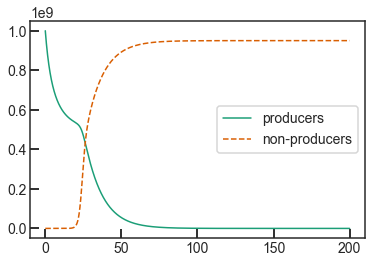

In [15]:
# naive simulations

K = 1e9
D = 0.1
kMB = 1e-6
muN = 2
muP = 0.2
beta_p = 1
n_cassettes = 1
selection = 'additive'
dt = 0.01
dt_mut = 0.01
t = 200
stochastic = False
cell_init = K
frac_at_dilution = 1.1


source, dest, rates, mus, beta_ps, pn_dict, pn_ind_dict = \
    naive_multicassette_mut_list_fixed_step(kMB, muN, muP, beta_p, n_cassettes, selection)
concs = np.zeros(len(mus)+1)
concs[0] = cell_init
out = np.zeros((int(t/dt)+1,len(concs)))
out[0,:]=concs
out = multicassette_naive_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                         frac_at_dilution)
producers = out[:,pn_ind_dict['producers']].sum(axis=1)
mutants = out[:,pn_ind_dict['mutants']].sum(axis=1)
prod = out[:,-1]
time = np.linspace(0,t,int(t/dt)+1)

fig, ax = plt.subplots()
ax.plot(time,producers,'-')
ax.plot(time,mutants,'--')
ax.legend(['producers','non-producers'])
# ax.set_yscale('log')

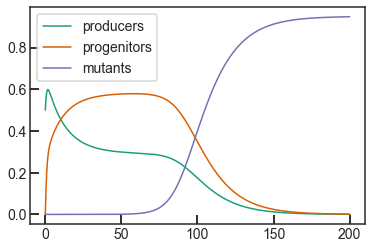

In [17]:
# diff simulations

K = 1e9
D = 0.1
kMB = 1e-6
kMD = 1e-6
muN = 2
muP = 0.2
kdiff = muN*0.3
beta_p = 1
n_cassettes = 1
selection = 'additive'
dt = dt_mut = 0.01
# dt = 0.01
# dt_mut = 0.10
t = 200
stochastic = False
cell_init = K/2
frac_at_dilution = 1.1


source, dest, rates, mus, beta_ps, ppm_dict, ppm_ind_dict = \
    diff_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                           n_cassettes)
concs = np.zeros(len(mus)+1)
concs[0] = cell_init
out = np.zeros((int(t/dt)+1,len(concs)))
out[0,:]=concs
# out = diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
#                                          frac_at_dilution)
out = multicassette_diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                         frac_at_dilution)
producers = out[:,ppm_ind_dict['producers']].sum(axis=1)/K
progenitors = out[:,ppm_ind_dict['progenitors']].sum(axis=1)/K
mutants = out[:,ppm_ind_dict['mutants']].sum(axis=1)/K
prod = out[:,-1]
time = np.linspace(0,t,int(t/dt)+1)

fig, ax = plt.subplots()
ax.plot(time,progenitors)
ax.plot(time,producers)
ax.plot(time,mutants)
ax.legend(['producers','progenitors','mutants'])

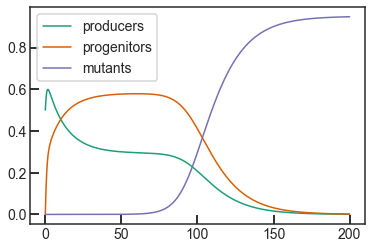

In [18]:
# diff select simulations

K = 1e9
D = 0.1
kMB = 1e-6
kMD = 1e-6
muN = 2
muP = 0.2
kdiff = muN*0.3
beta_p = 1
n_cassettes = 1
selection = 'additive'
dt = dt_mut = 0.01
n_div = 4
# dt = 0.01
# dt_mut = 0.10
t = 200
stochastic = False
cell_init = K/2
frac_at_dilution = 1.1


source, dest, rates, mus, beta_ps, diff_div_loss_locs, diff_div_gain_locs, ppmn_dict, ppmn_ind_dict = \
    diff_select_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                           n_cassettes,n_div)
concs = np.zeros(len(mus)+1)
concs[0] = cell_init
out = np.zeros((int(t/dt)+1,len(concs)))
out[0,:]=concs
# out = diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
#                                          frac_at_dilution)
out = multicassette_diff_select_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                         frac_at_dilution,diff_div_loss_locs, diff_div_gain_locs)
producers = out[:,ppmn_ind_dict['producers']].sum(axis=1)/K
progenitors = out[:,ppmn_ind_dict['progenitors']].sum(axis=1)/K
mutants = out[:,ppmn_ind_dict['mutants']].sum(axis=1)/K
prod = out[:,-1]
time = np.linspace(0,t,int(t/dt)+1)

fig, ax = plt.subplots()
ax.plot(time,progenitors)
ax.plot(time,producers)
ax.plot(time,mutants)
ax.legend(['producers','progenitors','mutants'])

Below we run the simulations used for generating Figure 1D-H and compile the results in dataframes

In [9]:
K = 1e9
D = 0.1
kMB = 1e-6
kMD = 1e-6
muN = 2
beta_p = 1
n_cassettes = 1
selection = 'additive'
dt = dt_mut = 0.01
t = 1000
stochastic = False
cell_init = K*0.8
frac_at_dilution = 1.1
kdiff = muN*0.3
n_div = 4
muPs = np.arange(1,10)/5
naive_df_columns = ['burden','muN','muP','kMB','K','D','beta_p','dt','producers','non-producers',
                    'production','total_production','duration']
naive_res = []
for i, muP in enumerate(muPs):
    #naive
    source, dest, rates, mus, beta_ps, pn_dict, pn_ind_dict = \
    naive_multicassette_mut_list_fixed_step(kMB, muN, muP, beta_p, n_cassettes, selection)
    concs = np.zeros(len(mus)+1)
    concs[0] = cell_init
    out = np.zeros((int(t/dt)+1,len(concs)))
    out[0,:]=concs
    out = multicassette_naive_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                             frac_at_dilution)
    producers = out[:,pn_ind_dict['producers']].sum(axis=1)/K
    cheaters = out[:,pn_ind_dict['cheaters']].sum(axis=1)/K
    prod = out[:,-1]
    t_end = dt*np.argwhere(prod>(0.95*prod.max())).min()
    burden= round((muN-muP)/muN,1)
    naive_res.append([burden,muN,muP,kMB,K,D,beta_p,dt,producers,cheaters,prod,prod.max(),t_end])
naive_df = pd.DataFrame(data=naive_res,columns=naive_df_columns)


In [10]:
K = 1e9
D = 0.1
kMB = 1e-6
kMDs = [1e-6,1e-12,1e-18]
muN = 2
beta_p = 1
n_cassettes = 1
selection = 'additive'
dt = dt_mut = 0.01
t = 1000
stochastic = False
cell_init = K*0.8
frac_at_dilution = 1.1
kdiff = muN*0.3
n_div = 4
muPs = np.arange(1,10)/5
diff_df_columns = ['burden','muN','muP','kMB','kMD','kdiff','K','D','beta_p','dt','producers','progenitors',
                   'non-producers','non-differentiators','production','total_production','duration']
diff_res = []
for i, muP in enumerate(muPs):
    for kMD in kMDs:
        #diff
        source, dest, rates, mus, beta_ps, ppm_dict, ppm_ind_dict = \
        diff_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                               n_cassettes)
        concs = np.zeros(len(mus)+1)
        concs[0] = cell_init
        out = np.zeros((int(t/dt)+1,len(concs)))
        out[0,:]=concs
        out = multicassette_diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                 frac_at_dilution)
        producers = out[:,ppm_ind_dict['producers']].sum(axis=1)/K
        progenitors = out[:,ppm_ind_dict['progenitors']].sum(axis=1)/K
        cheaters = out[:,ppm_ind_dict['cheaters']].sum(axis=1)/K
        defectors = out[:,ppm_ind_dict['defectors']].sum(axis=1)/K
        prod = out[:,-1]
        t_end = dt*np.argwhere(prod>(0.95*prod.max())).min()
        burden= round((muN-muP)/muN,1)
        diff_res.append([burden,muN,muP,kMB,kMD,kdiff,K,D,beta_p,dt,producers,progenitors,
                         cheaters,defectors,prod,prod.max(),t_end])
diff_df = pd.DataFrame(data=diff_res,columns=diff_df_columns)


In [11]:
K = 1e9
D = 0.1
kMB = 1e-6
kMDs = [1e-6,1e-12,1e-18]
muN = 2
beta_p = 1
n_cassettes = 1
selection = 'additive'
dt = dt_mut = 0.01
t = 1000
stochastic = False
cell_init = K*0.8
frac_at_dilution = 1.1
kdiff = muN*0.3
n_divs = [4,8]
muPs = np.arange(1,10)/5
term_diff_df_columns = ['burden','muN','muP','kMB','kMD','kdiff','n_div','K','D','beta_p','dt','producers','progenitors',
                   'non-producers','non-differentiators','production','total_production','duration']
term_diff_res = []
for i, muP in enumerate(muPs):
    for kMD in kMDs:
        for n_div in n_divs:
            #diff select
            source, dest, rates, mus, beta_ps, diff_div_loss_locs, diff_div_gain_locs, ppmn_dict, ppmn_ind_dict = \
            diff_select_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                                   n_cassettes,n_div)
            concs = np.zeros(len(mus)+1)
            concs[0] = cell_init
            out = np.zeros((int(t/dt)+1,len(concs)))
            out[0,:]=concs
            out = multicassette_diff_select_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                     frac_at_dilution,diff_div_loss_locs, diff_div_gain_locs)
            producers = out[:,ppmn_ind_dict['producers']].sum(axis=1)/K
            progenitors = out[:,ppmn_ind_dict['progenitors']].sum(axis=1)/K
            cheaters = out[:,ppmn_ind_dict['cheaters']].sum(axis=1)/K
            defectors = out[:,ppmn_ind_dict['defectors']].sum(axis=1)/K
            prod = out[:,-1]
            t_end = dt*np.argwhere(prod>(0.95*prod.max())).min()
            burden= round((muN-muP)/muN,1)
            term_diff_res.append([burden,muN,muP,kMB,kMD,kdiff,n_div,K,D,beta_p,dt,producers,progenitors,
                             cheaters,defectors,prod,prod.max(),t_end])
term_diff_df = pd.DataFrame(data=term_diff_res,columns=term_diff_df_columns)

Below we generate the plots shown in Figure 1 D-H.

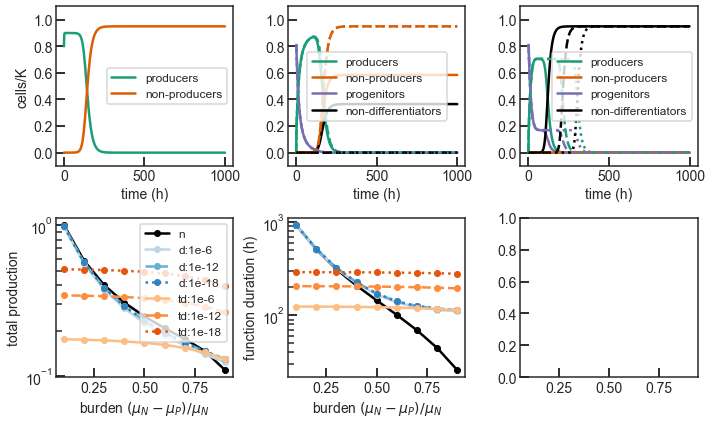

In [13]:

colors = ['#1b9e77','#d95f02','#7570b3']
lw=2.5
sns.set_palette(colors)
fig,ax=plt.subplots(2,3,figsize=(10,6),sharex='row',sharey=False)

prod_max = max([naive_df.total_production.max(),diff_df.total_production.max(),term_diff_df.total_production.max()])
burden = 0.5
#naive
producers = naive_df.loc[naive_df.burden==burden,'producers'].values[0]
nonproducers = naive_df.loc[naive_df.burden==burden,'non-producers'].values[0]
ax[0,0].plot(np.arange(len(producers))*dt,producers,color=colors[0],lw=lw)
ax[0,0].plot(np.arange(len(producers))*dt,nonproducers,color=colors[1],lw=lw)
ax[0,0].legend(['producers','non-producers'],loc='best',fontsize=12)    
#diff
lss=['-','--',':']
n_div=4
for i, kMD in enumerate([1e-6,1e-12,1e-18]):
    producers = diff_df.loc[(diff_df.burden==burden)&\
                            (diff_df.kMD==kMD),'producers'].values[0]
    nonproducers = diff_df.loc[(diff_df.burden==burden)&\
                            (diff_df.kMD==kMD),'non-producers'].values[0]
    progenitors = diff_df.loc[(diff_df.burden==burden)&\
                            (diff_df.kMD==kMD),'progenitors'].values[0]
    nondiffs = diff_df.loc[(diff_df.burden==burden)&\
                            (diff_df.kMD==kMD),'non-differentiators'].values[0]
    ax[0,1].plot(np.arange(len(producers))*dt,producers,color=colors[0],ls=lss[i],lw=lw)
    ax[0,1].plot(np.arange(len(producers))*dt,nonproducers,color=colors[1],ls=lss[i],lw=lw)
    ax[0,1].plot(np.arange(len(producers))*dt,progenitors,color=colors[2],ls=lss[i],lw=lw)    
    ax[0,1].plot(np.arange(len(producers))*dt,nondiffs,color='black',ls=lss[i],lw=lw)   
ax[0,1].legend(['producers','non-producers','progenitors','non-differentiators'],loc='best',fontsize=12)    
for i, kMD in enumerate([1e-6,1e-12,1e-18]):
    producers = term_diff_df.loc[(term_diff_df.burden==burden)&\
                            (term_diff_df.kMD==kMD)&\
                            (term_diff_df.n_div==n_div),'producers'].values[0]
    nonproducers = term_diff_df.loc[(term_diff_df.burden==burden)&\
                            (term_diff_df.kMD==kMD)&\
                            (term_diff_df.n_div==n_div),'non-producers'].values[0]
    progenitors = term_diff_df.loc[(term_diff_df.burden==burden)&\
                            (term_diff_df.kMD==kMD)&\
                            (term_diff_df.n_div==n_div),'progenitors'].values[0]
    nondiffs = term_diff_df.loc[(term_diff_df.burden==burden)&\
                            (term_diff_df.kMD==kMD)&\
                            (term_diff_df.n_div==n_div),'non-differentiators'].values[0]
    ax[0,2].plot(np.arange(len(producers))*dt,producers,color=colors[0],ls=lss[i],lw=lw)
    ax[0,2].plot(np.arange(len(producers))*dt,nonproducers,color=colors[1],ls=lss[i],lw=lw)
    ax[0,2].plot(np.arange(len(producers))*dt,progenitors,color=colors[2],ls=lss[i],lw=lw)    
    ax[0,2].plot(np.arange(len(producers))*dt,nondiffs,color='black',ls=lss[i],lw=lw) 
ax[0,2].legend(['producers','non-producers','progenitors','non-differentiators'],loc='best',fontsize=12)
ax[0,0].set_xlabel('time (h)',fontsize=14)
ax[0,1].set_xlabel('time (h)',fontsize=14)
ax[0,2].set_xlabel('time (h)',fontsize=14)
ax[0,0].set_ylabel('cells/K',fontsize=14)
for i in range(3):
    ax[0,i].set_ylim(-0.1,1.1)
    ax[0,i].set_yticks([0,0.2,0.4,0.6,0.8,1])
d_colors = ['#bdd7e7','#6baed6','#3182bd']
td_colors = ['#fdbe85','#fd8d3c','#e6550d']

ax[1,0].plot(naive_df.burden.values,naive_df.total_production.values/prod_max,marker='o',ms=6,color='black',lw=lw)
ax[1,1].plot(naive_df.burden.values,naive_df.duration.values,marker='o',ms=6,color='black',lw=lw)
# ax[1,0].legend(['naive'],loc='best',fontsize=12)     
# plot diff

for i, kMD in enumerate([1e-6,1e-12,1e-18]):
    ax[1,0].plot(diff_df.loc[diff_df.kMD==kMD,'burden'],
                 diff_df.loc[diff_df.kMD==kMD,'total_production']/prod_max,color=d_colors[i],marker='o',ms=6,ls=lss[i],lw=lw)
    ax[1,1].plot(diff_df.loc[diff_df.kMD==kMD,'burden'],
             diff_df.loc[diff_df.kMD==kMD,'duration'],color=d_colors[i],marker='o',ms=6,ls=lss[i],lw=lw)

for i, kMD in enumerate([1e-6,1e-12,1e-18]):
    ax[1,0].plot(term_diff_df.loc[(term_diff_df.kMD==kMD)&\
                                  (term_diff_df.n_div==4),'burden'],
                 term_diff_df.loc[(term_diff_df.kMD==kMD)&\
                                  (term_diff_df.n_div==4),'total_production']/prod_max,color=td_colors[i],marker='o',ms=6,ls=lss[i],lw=lw)
    ax[1,1].plot(term_diff_df.loc[(term_diff_df.kMD==kMD)&\
                                  (term_diff_df.n_div==4),'burden'],
             term_diff_df.loc[(term_diff_df.kMD==kMD)&\
                              (term_diff_df.n_div==4),'duration'],color=td_colors[i],marker='o',ms=6,ls=lss[i],lw=lw)
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,0].set_ylabel('total production',fontsize=14)
ax[1,1].set_ylabel('function duration (h)',fontsize=14)
ax[1,0].set_xlabel(f'burden $(\mu_N-\mu_P)/\mu_N$',fontsize=14)
ax[1,1].set_xlabel(f'burden $(\mu_N-\mu_P)/\mu_N$',fontsize=14)
ax[1,0].legend(['n','d:1e-6','d:1e-12','d:1e-18','td:1e-6','td:1e-12','td:1e-18'],loc='best',fontsize=12)
plt.tight_layout()
plt.savefig('20220713_timecourse_production_burden_plots.pdf')

Below we run the simulations used to generate Figure S1.

In [31]:
kMB = 1e-6
muN = 2
muPs = [1.8,1.6,1.4,1.0,0.6,0.2]
beta_p = 1
n_cassettes = 1
dt = 0.01
D = 0.2
K = 1e9
t = 1000
cell_init = 0.8*K
selection = 'additive'

naive_burden_dict = {}
naive_columns = ['circuit','muN','muP','K','D','kMB','species_ind_dict','time',
                 'results','production_array','total_production']
diff_burden_dict = {}
ds_burden_dict = {}
naive_summary = []
for i, muP in enumerate(muPs):
    summary_add = []
    summary_add_dict = {}
    source, dest, rates, mus, beta_ps, pn_dict, pn_ind_dict = \
    naive_multicassette_mut_list_fixed_step(kMB, muN, muP, beta_p, n_cassettes, selection)
    concs = np.zeros(len(mus)+1)
    concs[0] = cell_init
    out = np.zeros((int(t/dt)+1,len(concs)))
    out[0,:]=concs
    out = multicassette_naive_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                             frac_at_dilution)
    prod = out[:,-1]
    summary_add_dict['circuit'] = 'naive'
    summary_add_dict['muN'] = muN
    summary_add_dict['muP'] = muP
    summary_add_dict['K'] = K
    summary_add_dict['D'] = D
    summary_add_dict['kMB'] = kMB
    summary_add_dict['species_ind_dict'] = pn_ind_dict
    summary_add_dict['time'] = np.arange(len(prod)) * dt
    summary_add_dict['results'] = out
    summary_add_dict['production_array'] = prod
    summary_add_dict['total_production'] = prod[-1]
    for column in naive_columns:
        summary_add.append(summary_add_dict[column])
    naive_summary.append(summary_add)

df_naive_burden = pd.DataFrame(columns=naive_columns, data=naive_summary)

In [32]:
kMB = 1e-6
muN = 2
muP = 0.6
beta_p = 1
n_cassettes = 1
dt = 0.01
D = 0.2
K = 1e9
t = 1000
cell_init = 0.8*K
selection = 'additive'
Ds = [0.2,0.4,0.6,0.8,1.0,1.2]
naive_summary = []
for i, D in enumerate(Ds):
    summary_add = []
    summary_add_dict = {}
    source, dest, rates, mus, beta_ps, pn_dict, pn_ind_dict = \
    naive_multicassette_mut_list_fixed_step(kMB, muN, muP, beta_p, n_cassettes, selection)
    concs = np.zeros(len(mus)+1)
    concs[0] = cell_init
    out = np.zeros((int(t/dt)+1,len(concs)))
    out[0,:]=concs
    out = multicassette_naive_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                             frac_at_dilution)
    prod = out[:,-1]
    summary_add_dict['circuit'] = 'naive'
    summary_add_dict['muN'] = muN
    summary_add_dict['muP'] = muP
    summary_add_dict['K'] = K
    summary_add_dict['D'] = D
    summary_add_dict['kMB'] = kMB
    summary_add_dict['species_ind_dict'] = pn_ind_dict
    summary_add_dict['time'] = np.arange(len(prod)) * dt
    summary_add_dict['results'] = out
    summary_add_dict['production_array'] = prod
    summary_add_dict['total_production'] = prod[-1]
    for column in naive_columns:
        summary_add.append(summary_add_dict[column])
    naive_summary.append(summary_add)
df_naive_D = pd.DataFrame(columns=naive_columns, data=naive_summary)

In [33]:
kMBs = [1e-3,1e-6,1e-9,1e-12,1e-15,1e-18]
D = 0.2
muP = 0.6
naive_summary = []
for i, kMB in enumerate(kMBs):
    summary_add = []
    summary_add_dict = {}
    source, dest, rates, mus, beta_ps, pn_dict, pn_ind_dict = \
    naive_multicassette_mut_list_fixed_step(kMB, muN, muP, beta_p, n_cassettes, selection)
    concs = np.zeros(len(mus)+1)
    concs[0] = cell_init
    out = np.zeros((int(t/dt)+1,len(concs)))
    out[0,:]=concs
    out = multicassette_naive_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                             frac_at_dilution)
    prod = out[:,-1]
    summary_add_dict['circuit'] = 'naive'
    summary_add_dict['muN'] = muN
    summary_add_dict['muP'] = muP
    summary_add_dict['K'] = K
    summary_add_dict['D'] = D
    summary_add_dict['kMB'] = kMB
    summary_add_dict['species_ind_dict'] = pn_ind_dict
    summary_add_dict['time'] = np.arange(len(prod)) * dt
    summary_add_dict['results'] = out
    summary_add_dict['production_array'] = prod
    summary_add_dict['total_production'] = prod[-1]
    for column in naive_columns:
        summary_add.append(summary_add_dict[column])
    naive_summary.append(summary_add)
df_naive_kMB = pd.DataFrame(columns=naive_columns, data=naive_summary)

In [34]:
kMB = 1e-6
muN = 2
muPs = [1.8,1.6,1.4,1.0,0.6,0.2]
beta_p = 1
n_cassettes = 1
dt = 0.01
D = 0.2
K = 1e9
t = 1000
cell_init = 0.8*K

kMD = 1e-6
kdiff = 0.4

diff_burden_dict = {}
diff_columns = ['circuit','muN','muP','K','D','kdiff','kMB','kMD','species_ind_dict','time',
                 'results','production_array','total_production']

diff_summary = []
for i, muP in enumerate(muPs):
    summary_add = []
    summary_add_dict = {}
    source, dest, rates, mus, beta_ps, ppm_dict, ppm_ind_dict = \
    diff_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                           n_cassettes)
    concs = np.zeros(len(mus)+1)
    concs[0] = cell_init
    out = np.zeros((int(t/dt)+1,len(concs)))
    out[0,:]=concs
    out = multicassette_diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                             frac_at_dilution)
    prod = out[:,-1]
    summary_add_dict['circuit'] = 'diff'
    summary_add_dict['muN'] = muN
    summary_add_dict['muP'] = muP
    summary_add_dict['K'] = K
    summary_add_dict['D'] = D
    summary_add_dict['kdiff'] = kdiff    
    summary_add_dict['kMB'] = kMB
    summary_add_dict['kMD'] = kMD    
    summary_add_dict['species_ind_dict'] = pn_ind_dict
    summary_add_dict['time'] = np.arange(len(prod)) * dt
    summary_add_dict['results'] = out
    summary_add_dict['production_array'] = prod
    summary_add_dict['total_production'] = prod[-1]
    for column in diff_columns:
        summary_add.append(summary_add_dict[column])
    diff_summary.append(summary_add)

df_diff_burden = pd.DataFrame(columns=diff_columns, data=diff_summary)

In [35]:
kMB = 1e-6
muN = 2
muP = 0.6
kdiffs = [0.1,0.2,0.4,0.6,0.8,1.0,1.2]
beta_p = 1
n_cassettes = 1
dt = 0.01
D = 0.2
K = 1e9
t = 1000
cell_init = 0.8*K

kMD = 1e-6
kdiff = 0.6

diff_columns = ['circuit','muN','muP','K','D','kdiff','kMB','kMD','species_ind_dict','time',
                 'results','production_array','total_production']

diff_summary = []
for i, kdiff in enumerate(kdiffs):
    summary_add = []
    summary_add_dict = {}
    source, dest, rates, mus, beta_ps, ppm_dict, ppm_ind_dict = \
    diff_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                           n_cassettes)
    concs = np.zeros(len(mus)+1)
    concs[0] = cell_init
    out = np.zeros((int(t/dt)+1,len(concs)))
    out[0,:]=concs
    out = multicassette_diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                             frac_at_dilution)
    prod = out[:,-1]
    summary_add_dict['circuit'] = 'diff'
    summary_add_dict['muN'] = muN
    summary_add_dict['muP'] = muP
    summary_add_dict['K'] = K
    summary_add_dict['D'] = D
    summary_add_dict['kdiff'] = kdiff    
    summary_add_dict['kMB'] = kMB
    summary_add_dict['kMD'] = kMD    
    summary_add_dict['species_ind_dict'] = pn_ind_dict
    summary_add_dict['time'] = np.arange(len(prod)) * dt
    summary_add_dict['results'] = out
    summary_add_dict['production_array'] = prod
    summary_add_dict['total_production'] = prod[-1]
    for column in diff_columns:
        summary_add.append(summary_add_dict[column])
    diff_summary.append(summary_add)

df_diff_kdiff = pd.DataFrame(columns=diff_columns, data=diff_summary)

In [36]:
kMB = 1e-6
muN = 2
muP = 0.6
kdiff = 0.4
beta_p = 1
n_cassettes = 1
dt = 0.01
Ds = [0.2,0.4,0.6,0.8,1.0,1.2]
K = 1e9
cell_init = 0.8*K
t = 1000
kMD = 1e-6
kdiff = 0.4

diff_columns = ['circuit','muN','muP','K','D','kdiff','kMB','kMD','species_ind_dict','time',
                 'results','production_array','total_production']

diff_summary = []
for i, D in enumerate(Ds):
    summary_add = []
    summary_add_dict = {}
    source, dest, rates, mus, beta_ps, ppm_dict, ppm_ind_dict = \
    diff_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                           n_cassettes)
    concs = np.zeros(len(mus)+1)
    concs[0] = cell_init
    out = np.zeros((int(t/dt)+1,len(concs)))
    out[0,:]=concs
    out = multicassette_diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                             frac_at_dilution)
    prod = out[:,-1]
    summary_add_dict['circuit'] = 'diff'
    summary_add_dict['muN'] = muN
    summary_add_dict['muP'] = muP
    summary_add_dict['K'] = K
    summary_add_dict['D'] = D
    summary_add_dict['kdiff'] = kdiff    
    summary_add_dict['kMB'] = kMB
    summary_add_dict['kMD'] = kMD    
    summary_add_dict['species_ind_dict'] = pn_ind_dict
    summary_add_dict['time'] = np.arange(len(prod)) * dt
    summary_add_dict['results'] = out
    summary_add_dict['production_array'] = prod
    summary_add_dict['total_production'] = prod[-1]
    for column in diff_columns:
        summary_add.append(summary_add_dict[column])
    diff_summary.append(summary_add)

df_diff_D = pd.DataFrame(columns=diff_columns, data=diff_summary)

In [37]:
kMBs = [1e-3,1e-6,1e-9,1e-12,1e-15,1e-18]
muN = 2
muP = 0.6
kdiff = 0.4
beta_p = 1
n_cassettes = 1
dt = 0.01
D = 0.2
K = 1e9
t = 1000
cell_init = 0.8*K

kMDs = [1e-3,1e-6,1e-9,1e-12,1e-18]

diff_columns = ['circuit','muN','muP','K','D','kdiff','kMB','kMD','species_ind_dict','time',
                 'results','production_array','total_production']

diff_summary = []
for j, kMB in enumerate(kMBs):
    for j, kMD in enumerate(kMDs):
        summary_add = []
        summary_add_dict = {}
        source, dest, rates, mus, beta_ps, ppm_dict, ppm_ind_dict = \
        diff_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                               n_cassettes)
        concs = np.zeros(len(mus)+1)
        concs[0] = cell_init
        out = np.zeros((int(t/dt)+1,len(concs)))
        out[0,:]=concs
        out = multicassette_diff_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                 frac_at_dilution)
        prod = out[:,-1]
        summary_add_dict['circuit'] = 'diff'
        summary_add_dict['muN'] = muN
        summary_add_dict['muP'] = muP
        summary_add_dict['K'] = K
        summary_add_dict['D'] = D
        summary_add_dict['kdiff'] = kdiff    
        summary_add_dict['kMB'] = kMB
        summary_add_dict['kMD'] = kMD    
        summary_add_dict['species_ind_dict'] = pn_ind_dict
        summary_add_dict['time'] = np.arange(len(prod)) * dt
        summary_add_dict['results'] = out
        summary_add_dict['production_array'] = prod
        summary_add_dict['total_production'] = prod[-1]
        for column in diff_columns:
            summary_add.append(summary_add_dict[column])
        diff_summary.append(summary_add)

df_diff_kMB_kMD = pd.DataFrame(columns=diff_columns, data=diff_summary)

In [38]:
kMB = 1e-6
muN = 2
muPs = [1.8,1.6,1.4,1.0,0.6,0.2]
beta_p = 1
n_cassettes = 1
dt = 0.01
D = 0.2
K = 1e9
t = 1000
cell_init = 0.8*K

kMD = 1e-6
kdiff = 0.4
n_div_array = [4,8]


ds_columns = ['circuit','muN','muP','K','D','kdiff','kMB','kMD','n_div','species_ind_dict','time',
                 'results','production_array','total_production']

ds_summary = []
for i, muP in enumerate(muPs):
    for n_div in n_div_array:
        summary_add = []
        summary_add_dict = {}
        source, dest, rates, mus, beta_ps, diff_div_loss_locs, diff_div_gain_locs, ppmn_dict, ppmn_ind_dict = \
        diff_select_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                               n_cassettes,n_div)
        concs = np.zeros(len(mus)+1)
        concs[0] = cell_init
        out = np.zeros((int(t/dt)+1,len(concs)))
        out[0,:]=concs
        out = multicassette_diff_select_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                 frac_at_dilution,diff_div_loss_locs, diff_div_gain_locs)
        prod = out[:,-1]
        summary_add_dict['circuit'] = 'term_diff'
        summary_add_dict['muN'] = muN
        summary_add_dict['muP'] = muP
        summary_add_dict['K'] = K
        summary_add_dict['D'] = D
        summary_add_dict['kdiff'] = kdiff    
        summary_add_dict['kMB'] = kMB
        summary_add_dict['kMD'] = kMD    
        summary_add_dict['n_div'] = n_div    
        summary_add_dict['species_ind_dict'] = pn_ind_dict
        summary_add_dict['time'] = np.arange(len(prod)) * dt
        summary_add_dict['results'] = out
        summary_add_dict['production_array'] = prod
        summary_add_dict['total_production'] = prod[-1]
        for column in ds_columns:
            summary_add.append(summary_add_dict[column])
        ds_summary.append(summary_add)

df_ds_burden = pd.DataFrame(columns=ds_columns, data=ds_summary)

In [39]:
kMB = 1e-6
muN = 2
muP = 0.6
beta_p = 1
n_cassettes = 1
dt = 0.01
D = 0.2
K = 1e9
t = 1000
cell_init = 0.8*K

kMD = 1e-6
kdiffs = [0.1,0.2,0.4,0.6,0.8,1.0,1.2]
n_div_array = [4,8]


ds_columns = ['circuit','muN','muP','K','D','kdiff','kMB','kMD','n_div','species_ind_dict','time',
                 'results','production_array','total_production']

ds_summary = []
for i, kdiff in enumerate(kdiffs):
    for n_div in n_div_array:
        summary_add = []
        summary_add_dict = {}
        source, dest, rates, mus, beta_ps, diff_div_loss_locs, diff_div_gain_locs, ppmn_dict, ppmn_ind_dict = \
        diff_select_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                               n_cassettes,n_div)
        concs = np.zeros(len(mus)+1)
        concs[0] = cell_init
        out = np.zeros((int(t/dt)+1,len(concs)))
        out[0,:]=concs
        out = multicassette_diff_select_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                 frac_at_dilution,diff_div_loss_locs, diff_div_gain_locs)
        prod = out[:,-1]
        summary_add_dict['circuit'] = 'term_diff'
        summary_add_dict['muN'] = muN
        summary_add_dict['muP'] = muP
        summary_add_dict['K'] = K
        summary_add_dict['D'] = D
        summary_add_dict['kdiff'] = kdiff    
        summary_add_dict['kMB'] = kMB
        summary_add_dict['kMD'] = kMD    
        summary_add_dict['n_div'] = n_div    
        summary_add_dict['species_ind_dict'] = pn_ind_dict
        summary_add_dict['time'] = np.arange(len(prod)) * dt
        summary_add_dict['results'] = out
        summary_add_dict['production_array'] = prod
        summary_add_dict['total_production'] = prod[-1]
        for column in ds_columns:
            summary_add.append(summary_add_dict[column])
        ds_summary.append(summary_add)

df_ds_kdiff = pd.DataFrame(columns=ds_columns, data=ds_summary)

In [40]:
kMB = 1e-6
muN = 2
muP = 0.6
beta_p = 1
n_cassettes = 1
dt = 0.01
Ds = [0.2,0.4,0.6,0.8,1.0,1.2]
K = 1e9
t = 1000
cell_init = 0.8*K

kMD = 1e-6
kdiff = 0.4
n_div_array = [4,8]


ds_columns = ['circuit','muN','muP','K','D','kdiff','kMB','kMD','n_div','species_ind_dict','time',
                 'results','production_array','total_production']

ds_summary = []
for i, D in enumerate(Ds):
    for n_div in n_div_array:
        summary_add = []
        summary_add_dict = {}
        source, dest, rates, mus, beta_ps, diff_div_loss_locs, diff_div_gain_locs, ppmn_dict, ppmn_ind_dict = \
        diff_select_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                               n_cassettes,n_div)
        concs = np.zeros(len(mus)+1)
        concs[0] = cell_init
        out = np.zeros((int(t/dt)+1,len(concs)))
        out[0,:]=concs
        out = multicassette_diff_select_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                 frac_at_dilution,diff_div_loss_locs, diff_div_gain_locs)
        prod = out[:,-1]
        summary_add_dict['circuit'] = 'term_diff'
        summary_add_dict['muN'] = muN
        summary_add_dict['muP'] = muP
        summary_add_dict['K'] = K
        summary_add_dict['D'] = D
        summary_add_dict['kdiff'] = kdiff    
        summary_add_dict['kMB'] = kMB
        summary_add_dict['kMD'] = kMD    
        summary_add_dict['n_div'] = n_div    
        summary_add_dict['species_ind_dict'] = pn_ind_dict
        summary_add_dict['time'] = np.arange(len(prod)) * dt
        summary_add_dict['results'] = out
        summary_add_dict['production_array'] = prod
        summary_add_dict['total_production'] = prod[-1]
        for column in ds_columns:
            summary_add.append(summary_add_dict[column])
        ds_summary.append(summary_add)

df_ds_D = pd.DataFrame(columns=ds_columns, data=ds_summary)

In [41]:
kMBs = [1e-3,1e-6,1e-9,1e-12,1e-15,1e-18]
muN = 2
muP = 0.6
beta_p = 1
n_cassettes = 1
dt = 0.01
D = 0.2
K = 1e9
t = 1000
cell_init = 0.8*K

kMDs = [1e-3,1e-6,1e-9,1e-12,1e-15,1e-18]
kdiff = 0.4
n_div_array = [4,8]
ds_columns = ['circuit','muN','muP','K','D','kdiff','kMB','kMD','n_div','species_ind_dict','time',
                 'results','production_array','total_production']

ds_summary = []
for j, kMB in enumerate(kMBs):
    for j, kMD in enumerate(kMDs):
        for n_div in n_div_array:
            summary_add = []
            summary_add_dict = {}
            source, dest, rates, mus, beta_ps, diff_div_loss_locs, diff_div_gain_locs, ppmn_dict, ppmn_ind_dict = \
            diff_select_multicassette_mut_list_fixed_step(kdiff, kMB, kMD, muN, muP, beta_p,
                                                   n_cassettes,n_div)
            concs = np.zeros(len(mus)+1)
            concs[0] = cell_init
            out = np.zeros((int(t/dt)+1,len(concs)))
            out[0,:]=concs
            out = multicassette_diff_select_fixed_step_growth(out,K,D,source,dest,rates,mus,beta_ps,dt,dt_mut,stochastic,
                                                     frac_at_dilution,diff_div_loss_locs, diff_div_gain_locs)
            prod = out[:,-1]
            summary_add_dict['circuit'] = 'diff'
            summary_add_dict['muN'] = muN
            summary_add_dict['muP'] = muP
            summary_add_dict['K'] = K
            summary_add_dict['D'] = D
            summary_add_dict['kdiff'] = kdiff    
            summary_add_dict['kMB'] = kMB
            summary_add_dict['kMD'] = kMD    
            summary_add_dict['n_div'] = n_div    
            summary_add_dict['species_ind_dict'] = pn_ind_dict
            summary_add_dict['time'] = np.arange(len(prod)) * dt
            summary_add_dict['results'] = out
            summary_add_dict['production_array'] = prod
            summary_add_dict['total_production'] = prod[-1]
            for column in ds_columns:
                summary_add.append(summary_add_dict[column])
            ds_summary.append(summary_add)

df_ds_kMB_kMD = pd.DataFrame(columns=ds_columns, data=ds_summary)

Below we generate the plots show in Figure S1

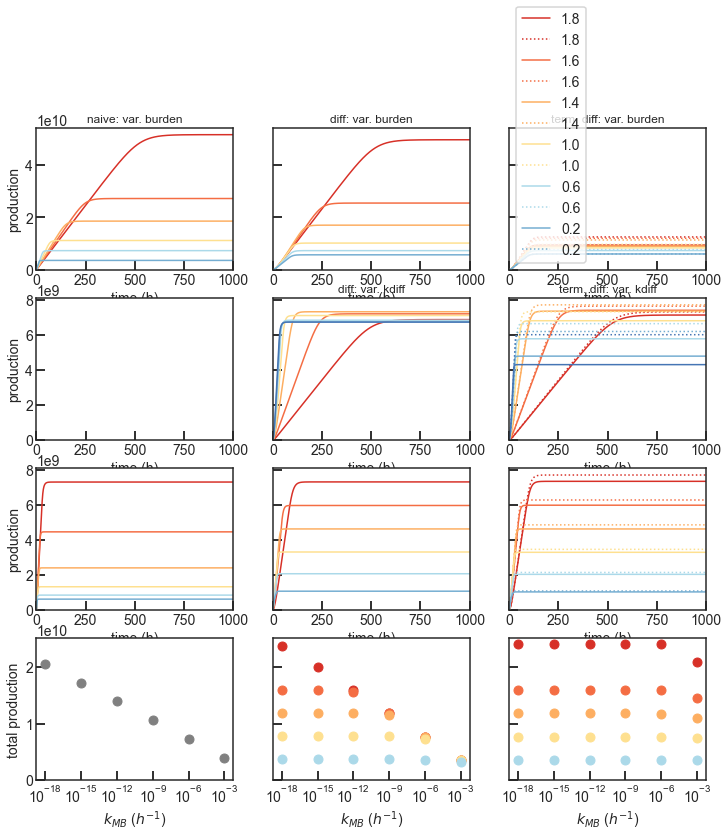

In [42]:

# with production 3x3
colors = ['#1b9e77','#d95f02','#7570b3']
colors_dict = {'producers':'#1b9e77','cheaters':'#d95f02','progenitors':'#7570b3','defectors':'#e7298a'}
# colors_dict = {'producers':'#1f78b4','cheaters':'#b2df8a','progenitors':'#a6cee3','defectors':'#33a02c'}
sns.set_palette(['#d73027','#f46d43','#fdae61','#fee090','#abd9e9','#74add1','#4575b4'])
fig,ax=plt.subplots(4,3,figsize=(12,12),sharex='row',sharey='row')
prod_colors = ['#ef8a62','#67a9cf']
prod_colors = ['#cccccc','#525252']
ls = ['-',':']

muPs = df_naive_burden.muP.unique()
for i, muP in enumerate(muPs):
    ax[0,0].plot(df_naive_burden.loc[df_naive_burden.muP==muP,'time'].values[0],
        df_naive_burden.loc[df_naive_burden.muP==muP,'production_array'].values[0])
    ax[0,1].plot(df_diff_burden.loc[df_diff_burden.muP==muP,'time'].values[0],
        df_diff_burden.loc[df_diff_burden.muP==muP,'production_array'].values[0])
    for j, n_div in enumerate([4,8]):
        ax[0,2].plot(df_ds_burden.loc[(df_ds_burden.muP==muP)&\
                                      (df_ds_burden.n_div==n_div),'time'].values[0],
                    df_ds_burden.loc[(df_ds_burden.muP==muP)&\
                                     (df_ds_burden.n_div==n_div),'production_array'].values[0],
                    color=sns.color_palette()[i],ls=ls[j])
kdiffs = df_diff_kdiff.kdiff.unique()
for i, kdiff in enumerate(kdiffs):
    ax[1,1].plot(df_diff_kdiff.loc[df_diff_kdiff.kdiff==kdiff,'time'].values[0],
            df_diff_kdiff.loc[df_diff_kdiff.kdiff==kdiff,'production_array'].values[0])
    for j, n_div in enumerate([4,8]):
        ax[1,2].plot(df_ds_kdiff.loc[(df_ds_kdiff.kdiff==kdiff)&\
                                      (df_ds_kdiff.n_div==n_div),'time'].values[0],
                df_ds_kdiff.loc[(df_ds_kdiff.kdiff==kdiff)&\
                                      (df_ds_kdiff.n_div==n_div),'production_array'].values[0],
                    color=sns.color_palette()[i],ls=ls[j])
Ds = df_naive_D.D.unique()
for i, D in enumerate(Ds):
    ax[2,0].plot(df_naive_D.loc[df_naive_D.D==D,'time'].values[0],
            df_naive_D.loc[df_naive_D.D==D,'production_array'].values[0])
    ax[2,1].plot(df_diff_D.loc[df_diff_D.D==D,'time'].values[0],
            df_diff_D.loc[df_diff_D.D==D,'production_array'].values[0])
    for j, n_div in enumerate([4,8]):
        ax[2,2].plot(df_ds_D.loc[(df_ds_D.D==D)&\
                                 (df_ds_D.n_div==n_div),'time'].values[0],
                df_ds_D.loc[(df_ds_D.D==D)&\
                                 (df_ds_D.n_div==n_div),'production_array'].values[0],
                    color=sns.color_palette()[i],ls=ls[j])
ax[3,0].plot(df_naive_kMB['kMB'].values,df_naive_kMB['total_production'].values,'o',color='grey')
ax[3,0].set_xscale('log')
for i, kMD in enumerate(df_diff_kMB_kMD.kMD.unique()[::-1]):
    ax[3,1].plot(df_diff_kMB_kMD.loc[df_diff_kMB_kMD.kMD==kMD,'kMB'].values,
                 df_diff_kMB_kMD.loc[df_diff_kMB_kMD.kMD==kMD,'total_production'].values,
                 'o',color=sns.color_palette()[i])
    ax[3,2].plot(df_ds_kMB_kMD.loc[(df_ds_kMB_kMD.kMD==kMD)&\
                                   (df_ds_kMB_kMD.n_div==8),'kMB'].values,
                 df_ds_kMB_kMD.loc[(df_ds_kMB_kMD.kMD==kMD)&\
                                   (df_ds_kMB_kMD.n_div==8),'total_production'].values,
                 'o',color=sns.color_palette()[i])
    
ax[0,2].legend(np.repeat(muPs,2))    
ax[0,0].set_ylabel('production',fontsize=14)
ax[1,0].set_ylabel('production',fontsize=14)
ax[2,0].set_ylabel('production',fontsize=14)
ax[3,0].set_ylabel('total production',fontsize=14)
for i in range(3):
    ax[3,i].set_xlabel('$k_{MB}$ ($h^{-1}$)',fontsize=14)
    for j in range(3):
        ax[i,j].set_xlabel('time (h)',fontsize=14)
ax[0,0].set_title('naive: var. burden',fontsize=12)
ax[0,1].set_title('diff: var. burden',fontsize=12)
ax[0,2].set_title('term. diff: var. burden',fontsize=12)
ax[1,1].set_title('diff: var. kdiff',fontsize=12)
ax[1,2].set_title('term. diff: var. kdiff',fontsize=12)
ax[3,0].set_xticks(kMBs)
for i in range(4):
    ax[i,0].set_ylim(0,)
for i in range(3):
    ax[i,0].set_xlim(0,1000)
plt.savefig('20220215_figure_s1.pdf')

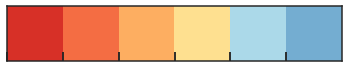

In [43]:
# for legend
sns.palplot(['#d73027','#f46d43','#fdae61','#fee090','#abd9e9','#74add1'])
plt.savefig('20220215_palplot.pdf')